## 10/26/2021
Based on this I wanted to get a feel from you on which topics you would be more interested in.  In other words, this intro touched on multibody formulation, differential algebraic equations, and Julia packages. Given this, are you comfortable with Julia to write a small program in Julia to define:
The 3D motion (translation and rotation) of a rigid body using both Cardan and quaternion
* A joint formulation (e.g. revolute) joint
* You may use the DifferentialEquations package to help you solve the model
* It would be an asset to show both Cartesian and joint based formulation. 
 
In you work, show the different forms of equations and possible solution methods

What I meant is to get familiar with the formulation of 3D body.  So basically write down the equations of motion using any principal you learned (like Newton-Euler, Lagrange, Hamilton) and use rotation parameters like Cardan/quaternion angles to define the motion of the body.  You could use ModelingToolkit to make it easier.  Then you could add equation of joint constraints to solve it all together.  This is basically to get you familiar with multibody formulation.

## Calculate rotation matrix R using three methods
Rotating around x axis(1,0,0) $\pi/4$, then rotating y axis, $\pi/4$, finally rotating z axis $\pi/4$
* **Method 1: Obtain rotation matrix using Cardan**

In [11]:
using LinearAlgebra

In [69]:
function CardanR(x,y,z) #CardanR method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rx*Ry*Rz
end
# aa=CardanR(pi/4,0,pi/4)
# tr(CardanR(pi/2,pi/2,pi/2))
# aa

CardanR (generic function with 1 method)

* **Method 2:Exponitial**

In [68]:
function ExptoR(omega,theta) #Expontial method for rotating around x,y,z axis respectively to get the rotation matrix R
    braketw=[0 -omega[3] omega[2]; omega[3] 0 -omega[1];-omega[2] omega[1] 0]
    R=I(3)+sin(theta)*braketw+(1-cos(theta))*braketw^2
    return R
end
# ExptoR(bb[3],bb[1])

ExptoR (generic function with 1 method)

In [60]:
function bracket(omega)
    return [0 -omega[3] omega[2]; omega[3] 0 -omega[1];-omega[2] omega[1] 0]
#     return [0 -omega[3] omega(2) v(1); omega(3) 0 -omega(1) v(2);-omega(2) omega(1) 0 v(3); 0 0 0 0]
end

function InversJ(euler)
    if cos(euler[2]) == 0 #try to solve singularity at theta = 0
        x = [1 sin(euler[1])*tan(euler[2]) cos(euler[1])*tan(euler[2]);0 cos(euler[1]) -sin(euler[1]);0 0 0]
    else
        x = [1 sin(euler[1])*tan(euler[2]) cos(euler[1])*tan(euler[2]);0 cos(euler[1]) -sin(euler[1]);0 sin(euler[1])/cos(euler[2]) cos(euler[1])/cos(euler[2])]
    end
    return x
end
#p=omega[1]  q= omega[2] r=omega[3]
function BraketQuart(omega)
    return [0 -omega[1] -omega[2] -omega[3]; omega[1] 0 omega[3] -omega[2]; omega[2] -omega[3] 0 omega[1]; omega[3] omega[2] -omega[1] 0]
end

BraketQuart (generic function with 1 method)

In [67]:
function rotateRtotheta(R)#converting rotataing matrix back to theta and omega
    theta=acos(0.5*(tr(R)-1))
    braketw=1/(2*sin(theta))*(R-transpose(R))
    omega=[braketw[3,2],braketw[1,3],braketw[2,1]]
    return theta,braketw,omega
end
# bb=rotateRtotheta(aa)

rotateRtotheta (generic function with 1 method)

* **Method 3:Quaternion**

In [65]:
function QuaternionR(omega,theta)
    q = [cos(theta/2) omega[1]*sin(theta/2) omega[2]*sin(theta/2) omega[3]*sin(theta/2)]
    R = [(q[1]^2)+(q[2]^2)-(q[3]^2)-(q[4]^2) 2*(q[2]*q[3]-q[1]*q[4]) 2*(q[1]*q[3]+q[2]*q[4]);
        2*(q[1]*q[4]+q[2]*q[3]) (q[1]^2)-(q[2]^2)+(q[3]^2)-(q[4]^2) 2*(q[3]*q[4]-q[1]*q[2]);
        2*(q[2]*q[4]-q[1]*q[3]) 2*(q[1]*q[2]+q[3]*q[4]) (q[1]^2)-(q[2]^2)-(q[3]^2)+(q[4]^2)]
    return R
end      
# QuaternionR(bb[3],bb[1])

QuaternionR (generic function with 1 method)

## To sum up
Comparing the rotation matrix from the three method 

In [70]:
car=CardanR(pi/5,1.2,pi/3)
ang=rotateRtotheta(car)
ex=ExptoR(ang[3],ang[1])
qu=QuaternionR(ang[3],ang[1])
println("angle theta is ",ang[1])
println(car)
println(ex)
println(qu)

angle theta is 1.8731843145718488
[0.18117887723833684 -0.31381102063508376 0.9320390859672263; 0.9745486838678828 -0.069933846158658 -0.21298854413520565; 0.1320192304705377 0.9469064898338295 0.29315358141517367]
[0.18117887723833692 -0.31381102063508376 0.9320390859672263; 0.974548683867883 -0.06993384615865783 -0.2129885441352058; 0.13201923047053765 0.9469064898338295 0.29315358141517367]
[0.18117887723833698 -0.31381102063508365 0.9320390859672263; 0.9745486838678827 -0.06993384615865805 -0.2129885441352058; 0.13201923047053782 0.9469064898338295 0.2931535814151736]


In [ ]:
ad=[]

## Start: rigid body dynamic
* Moi matrix function wrt center of mass

In [71]:
#moi matrix function for a block wrt center of mass function
I_brick(Lx,Ly,Lz,m)=[(m*(Ly^2 + Lz^2)/12) 0 0; 0 (m*(Lx^2 + Lz^2)/12) 0;0 0 (m*(Lx^2 + Ly^2)/12)]
# I_brick(1,2,1,1)

3×3 Matrix{Float64}:
 0.416667  0.0       0.0
 0.0       0.166667  0.0
 0.0       0.0       0.416667

Euler method: $F=m(\dot{V_b}+\omega \times V_b)$ 
\begin{bmatrix}
i & j & k\\
p & q & r\\
u_b & v_b & w_b
\end{bmatrix}

* linear momentum equation:
$\omega \times V_b = (qw_b-rv_b) i + (ru_b-pw_b) j +(pv_b-qu_b) k$
so emo becomes $\frac{1}{m}F_b-\omega \times V_b = [\frac{F_x}{m}- (qw_b-rv_b)] i + [\frac{F_y}{m}- (ru_b-pw_b)] j +[\frac{F_z}{m}- (pv_b-qu_b)] k$ 
<!-- $ i+  j+    k$ -->
* Angular momentum equation:


In [ ]:
using DifferentialEquations
using LinearAlgebra
using ModelingToolkit
#u1=ub u2=vb u3=wb u4=p u5=q u6=r 
function Euler3D!(du,u,MOI,F,M,t)
    du[1] = F[1]/m-(u[5]*u[3]-u[6]*u[2])                    # θ'(t) = ω(t)
    du[2] = F[2]/m-(u[6]*u[1]-u[4]*u[3]) 
    du[3] = F[3]/m-(u[4]*u[2]-u[5]*u[1]) 
#     du[2] = -3g/(2l)*sin(u[1]) + 3/(m*l^2)*p(t) # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
end

θ₀ = 0.0                           # initial angular deflection [rad]
ω₀ = 0.0                            # initial angular velocity [rad/s]
u₀ = [θ₀, ω₀]   
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)

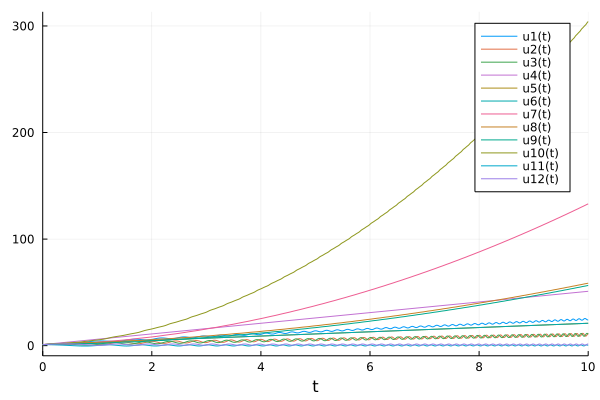

In [63]:
#use matrix method Euler
using DifferentialEquations
using LinearAlgebra
using Plots
M = [5,2,2]
F = [1,2,3]
m=1
MOI=I(3)
InvMOI=inv(MOI)
#u1=ub u2=vb u3=wb u4=p u5=q u6=r u7=x u8=y u9=z u10=phi u11=theta u12=psi
function Euler3D!(du,u,p,t)
    du[1:3]=F/m-bracket(u[4:6])*u[1:3]
    du[4:6]=InvMOI*(M-bracket(u[4:6])*(MOI*u[4:6]))
    du[7:9]=u[1:3]
    du[10:12]=InversJ(u[10:12])*u[4:6]
#   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
end
v0=[1.0 1.0 1.0]#initial linear velocity
w0=[1.0 1.0 1.0]#initial angular velocity
x0=[1.0 1.0 1.0] #initial position
theta0=[1.0 1.0 1.0]#initial angle
tspan=(0.0,10.0);
prob=ODEProblem(Euler3D!,u0,tspan)
sol=solve(prob)
plot(sol)

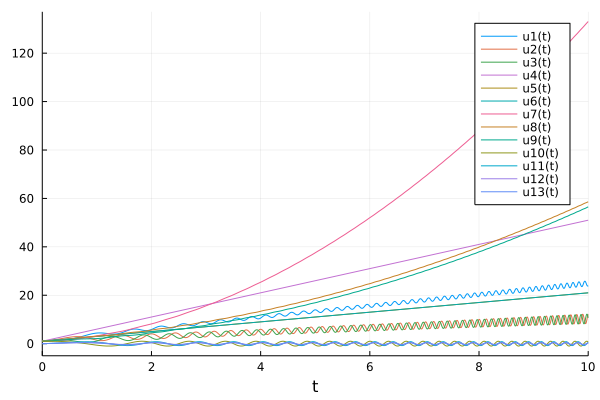

In [64]:
#use matrix method Quaternion
using DifferentialEquations
using LinearAlgebra
using Plots
M = [5,2,2]
F = [1,2,3]
K=1 #K is the gain that normalize the quaternion back to 1
m=1
MOI=I(3)
InvMOI=inv(MOI)
#u1=ub u2=vb u3=wb u4=p u5=q u6=r u7=x u8=y u9=z u10=phi u11=theta u12=psi
function Quaternion3D!(du,u,p,t)
    du[1:3]=F/m-bracket(u[4:6])*u[1:3]
    du[4:6]=InvMOI*(M-bracket(u[4:6])*(MOI*u[4:6]))
    du[7:9]=u[1:3]
    du[10:13]=1/2*BraketQuart(u[4:6])*u[10:13]+K*(1-(norm(u[10:13]))^2)*u[10:13]
#   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
end
v0=[1.0 1.0 1.0]#initial linear velocity
w0=[1.0 1.0 1.0]#initial angular velocity
x0=[1.0 1.0 1.0] #initial position
qu0=[1.0 0.0 0.0 0.0]#initial angle in quaternion
u0=[v0 w0 x0 qu0]
tspan=(0.0,10.0);
prob=ODEProblem(Quaternion3D!,u0,tspan)
sol=solve(prob)
plot(sol)

In [33]:
#use matrix method test
using DifferentialEquations
using LinearAlgebra
# M = [1,1,1]
# F = [1,1,1]
# C = 1
# function eq(du,u,F,M,t)
#     du[1:3]=-cross(u[1:3],F)
#     du[4:6]=-cross(u[4:6],M)
   
# #   du .= u[:,2] .- 10 - M./C.*u[:,2] - M.\K.*u[:,1]
# end
# u0=[1.0 1.0 1.0 1.0 1.0 1.0]
# tspan=(0.0,10.0);
# prob=ODEProblem(eq,u0,tspan)
# sol=solve(prob)

using DifferentialEquations
using LinearAlgebra
a=[3,4,5]
f(u,p,t) = 1.01*bracket(u)*a
u0 = [1/2,1/2,0]
tspan = (0.0,1.0)
prob = ODEProblem(f,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
MOI=I(3)
InvMOI=inv(MOI)

3×3 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅    ⋅ 
  ⋅   1.0   ⋅ 
  ⋅    ⋅   1.0

In [55]:
using LinearAlgebra
p=[3,4,5]
v=[2,3,5]
cross(p,v),bracket(p)*v
InversJ([0,pi/2,0])

3×3 Matrix{Float64}:
 1.0  0.0   1.63312e16
 0.0  1.0  -0.0
 0.0  0.0   1.63312e16